### Setup

In [102]:
import os
import xarray as xr
import pandas as pd
import dask
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import copy
import functools
import glob
import scipy

In [103]:
def get_surdat(surdat_file):
    """
    Read in CLM surface data file and pull out needed values
    
    """

    surdat = xr.open_dataset(surdat_file)

    # set actual latitude and longitude values as the dimension values
    surdat['lat'] = xr.DataArray(np.unique(surdat.LATIXY.values), dims='lsmlat')
    surdat['lon'] = xr.DataArray(np.unique(surdat.LONGXY.values), dims='lsmlon')
    surdat = surdat.swap_dims({'lsmlat': 'lat', 'lsmlon': 'lon'})

    surdat['PCT_NAT_PFT_UPDATED'] = (surdat.PCT_NAT_PFT*(surdat.PCT_NATVEG/100.0))
    surdat['PCT_CFT_UPDATED'] = (surdat.PCT_CFT*(surdat.PCT_CROP/100.0))

    out = surdat[['PCT_NAT_PFT_UPDATED', 'PCT_CFT_UPDATED']]

    lat = out.lat.data
    lon = out.lon.data
    out['dominant_pft_ind'] = xr.DataArray(
        data=999,
        dims=["lat", "lon"],
        coords=dict(
            lon=(["lon"], lon),
            lat=(["lat"], lat),
        )
    )
    out['dominant_pft'] = xr.DataArray(
        data='-'*500,
        dims=["lat", "lon"],
        coords=dict(
            lon=(["lon"], lon),
            lat=(["lat"], lat),
        )
    )

    return out

In [104]:
def get_dom_pfts(dat,threshold):
    all_pfts = np.append(dat.PCT_NAT_PFT_UPDATED.values, dat.PCT_CFT_UPDATED.values)
    non_veg = all_pfts[0]
    
    veg = all_pfts[1:]
    
    if (all_pfts.sum() >= threshold) & (non_veg <= 50):

            sum_veg = veg.sum()
            veg_prop = (veg/sum_veg)*100.0
            
            sorted_pfts = sorted(veg_prop, reverse=True)
            pft_sort = np.flip(np.argsort(veg_prop))
            
            if sorted_pfts[0] >= threshold:
                dom_pft_inds = [pft_sort[0].tolist()]
            else:
                cumul_prop = sorted_pfts[0]
                for i in range(1, len(sorted_pfts)):
                    cumul_prop = cumul_prop + sorted_pfts[i]
                    if cumul_prop >= threshold:
                        dom_pft_inds = pft_sort[:i+1].tolist()
                        break
            
            clm_pft_ind = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
            dom_pfts = [clm_pft_ind[i] for i in sorted(dom_pft_inds)]

    else:
        if non_veg >= threshold:
            dom_pfts = [0]
        else:
            dom_pfts = '-'
        
    return dom_pfts

### Setup

In [105]:
## Surface datasets
surdat_dir = "/glade/p/cesmdata/cseg/inputdata/lnd/clm2/surfdata_map/"
surdat_2deg = os.path.join(surdat_dir, "release-clm5.0.18", "surfdata_1.9x2.5_hist_16pfts_Irrig_CMIP6_simyr2000_c190304.nc")
surfdat = get_surdat(surdat_2deg)

In [106]:
filename = '/glade/derecho/scratch/linnia/BNF_v2.n01_ctsm5.3.012_transient_SP_0/run/BNF_v2.n01_ctsm5.3.012_transient_SP_0.clm2.h1.2000-02-01-00000.nc'
ds_sp = xr.open_dataset(filename)
landfrac = ds_sp.landfrac

In [107]:
# find lat lon of sparse grid
sg = xr.open_dataset('/glade/derecho/scratch/linnia/BNF_v2.n01_ctsm5.3.012_transient_lhc0000/run/BNF_v2.n01_ctsm5.3.012_transient_lhc0000.clm2.h0.2000-02-01-00000.nc',decode_timedelta=False)

In [108]:
veg_combos = {
    "Boreal shrubland": {tuple([12])},
    "Tundra": {tuple([11]),tuple(sorted([11, 12]))},
    "Boreal forest": {tuple([2]),tuple(sorted([2,11, 12])),tuple(sorted([2, 12])),tuple(sorted([2, 11]))},
    "Siberian larch" : {tuple(sorted([3])),tuple(sorted([11,3])),tuple(sorted([12,3])),tuple(sorted([11,12,3]))},
    
    "Tropical rainforest" : {tuple(sorted([4]))},
    "Tropical savanna": {tuple(sorted([4,14])),tuple(sorted([14]))},
    "Subtropical savanna" : {tuple(sorted([6,14])),tuple(sorted([4,6])),tuple(sorted([4,6,14]))},

    "Grasslands" : {tuple(sorted([13])),tuple(sorted([13,15])),tuple(sorted([13,14])),tuple(sorted([13,14,15]))},
    "Shrubland" :  {tuple(sorted([10,13])),tuple(sorted([10,14])),tuple(sorted([10,13,14])),tuple(sorted([10,13,15])),tuple(sorted([10,14,15])),tuple(sorted([10,13,14,15]))},
    
    
    "Mixed deciduous temperate forest" :  {tuple(sorted([7])),
                                           tuple(sorted([1,7])),
                                           tuple(sorted([7,13])),
                                           tuple(sorted([7,14])),
                                           tuple(sorted([7,15])),
                                           tuple(sorted([1,7,13])),
                                           tuple(sorted([1,7,14])),
                                           tuple(sorted([1,7,15])),
                                           tuple(sorted([1,7,13,15])),
                                           tuple(sorted([1,7,14,15])),
                                           tuple(sorted([1,7,13,14])),
                                           tuple(sorted([7,13,14])),
                                           tuple(sorted([7,13,15])),
                                           tuple(sorted([7,14,15])),
                                           tuple(sorted([7,13,14,15])),
                                           tuple(sorted([1,7,13,14,15]))},

    "Conifer forest" : {tuple(sorted([1])),
                        tuple(sorted([1,2])),
                        tuple(sorted([1,13])),
                        tuple(sorted([1,14])),
                        tuple(sorted([1,15])),
                        tuple(sorted([1,2,13])),
                        tuple(sorted([1,2,14])),
                        tuple(sorted([1,2,15])),
                        tuple(sorted([1,13,14])),
                        tuple(sorted([1,13,15])),
                        tuple(sorted([1,14,15])),
                        tuple(sorted([1,2,13,14])),
                        tuple(sorted([1,2,13,15])),
                        tuple(sorted([1,2,14,15])),
                        tuple(sorted([1,13,14,15])),
                        tuple(sorted([1,2,13,14,15]))},
    "Broadleaf deciduous boreal trees" : { tuple(sorted([8])),
               tuple(sorted([2,8])),
               tuple(sorted([8,12])),
               tuple(sorted([8,13])),
               tuple(sorted([8,15])),
               tuple(sorted([2,8,12])),
               tuple(sorted([2,8,13])),
               tuple(sorted([2,8,15])),
               tuple(sorted([8,12,13])),
               tuple(sorted([8,12,15])),
               tuple(sorted([8,13,15])),
               tuple(sorted([2,8,13,15])),
               tuple(sorted([2,8,12,13])),
               tuple(sorted([2,8,12,15])),
               tuple(sorted([2,8,12,13,15])),
              },

    "Broadleaf evergreen temperate tree" : {tuple(sorted([5])),
                    tuple(sorted([5,13])),
                    tuple(sorted([5,14])),
                    tuple(sorted([5,15])),
                    tuple(sorted([5,13,14])),
                    tuple(sorted([5,13,15])),
                    tuple(sorted([5,14,15])),
                    tuple(sorted([5,13,14,15]))}

}


### Spaarsegrid

In [29]:
# Find PFTs that sum to > threshold of vegetated portion of gridcell
threshold=80

lats = sg.grid1d_lat.values
lons = sg.grid1d_lon.values

dom_pft_data = np.empty((len(lats)), dtype=object)
for i in range(len(lats)):
    if landfrac.sel(lat=lats[i],method='nearest').sel(lon=lons[i],method='nearest')>0.05:
        dat = surfdat.sel(lat=lats[i], method='nearest').sel(lon=lons[i], method='nearest')
        dom_pft_data[i] = get_dom_pfts(dat, threshold)

# Store in an xarray Dataset
ds_out_sg = xr.Dataset(
    {
        "dom_pfts": (["gridcell"], dom_pft_data)
    },
    coords={
        "gridcell": range(400)
    }
)


In [30]:

# Flatten dataset into a list of (lat, lon, dom_pfts)
data_list = []
for i, lat in enumerate(ds_out_sg.gridcell.values):
        dom_pfts = ds_out_sg.dom_pfts.values[i]
        if dom_pfts is not None:  # Ensure valid data
            data_list.append((tuple(sorted(dom_pfts)), i))

# Convert to a Pandas DataFrame
df = pd.DataFrame(data_list, columns=["pft_combo", "gridcell"])

# Count occurrences of each unique PFT combination
pft_counts = df["pft_combo"].value_counts().reset_index()
pft_counts.columns = ["pft_combo", "count"]

In [10]:
pft_counts.to_csv('pftgroups_counts_sg.csv')

In [31]:
# create dataset of 2D biome masks
biome_masks_sg = {}

lats = sg.grid1d_lat.values
lons = sg.grid1d_lon.values

for biome_name, pft_combos in veg_combos.items():
    # Create a binary mask for the biome
    biome_mask = np.zeros((400), dtype=int)  

    for i in range(400):
            dom_pfts = ds_out_sg.dom_pfts.values[i] 
            
            if dom_pfts is not None:
                sorted_pfts = tuple(sorted(dom_pfts))  
                if sorted_pfts in pft_combos:
                    biome_mask[i] = 1  # Mark as 1 (true)

    # Store the mask in the dictionary
    biome_masks_sg[biome_name] = (["gridcell"], biome_mask)


sg_biome_masks = xr.Dataset(biome_masks_sg, coords={"gridcell": range(400)})


In [32]:
sg_biome_masks.to_netcdf('biome_masks_sparsegrid_80percent.nc')

In [34]:
in_file = '~/ctsm6_ppe/utils/landarea_retrain_h0.nc'
landarea = xr.open_dataset(in_file)
la = landarea.landarea

In [56]:
filename = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/postp/ctsm6lhc_grid_amean_1850-2023.nc'
ds_grid = xr.open_dataset(filename)

In [61]:
gpp = ds_grid.GPP_gridded_amean.sel(ens=0,year=slice('2001','2020')).mean(dim='year')

In [67]:
for var in sg_biome_masks.data_vars:
    
    biome_la = (sg_biome_masks[var]*la.values).sum()
    biome_gpp = (sg_biome_masks[var]*gpp.values).sum()*60*60*24*365*biome_la*1E-9
    print(var,sg_biome_masks[var].values.sum(),biome_la.values, biome_gpp.values)

Arctic shrub 10 1720368.060546875 8.755418280258533
Tundra 37 7534671.05078125 173.54488640950845
Boreal forest 24 4836526.613525391 116.35849603315968
Siberian larch 8 2782793.6875 25.52069065719992
Tropical rainforest 12 8143203.78125 334.1677823875362
Tropical forest grassland 29 10177949.55859375 613.1056663699554
Subtropical savanna 15 5813893.15625 101.8783733103111
Grasslands 32 14636767.741210938 442.7464714663346
Shrubland 21 14335771.666015625 135.22636263840027
Mixed deciduous temperate forest 18 7125927.51171875 166.61513771422528
Conifer forest 17 5027106.1171875 121.81849416311249
Aspen 5 1053184.05078125 7.1156940125672214
Eucalyptus 7 1495517.53125 22.01991730258925


In [39]:
(sg_biome_masks['Arctic shrub']*la.values).sum()

<xarray.DataArray 'Arctic shrub' ()> Size: 8B
array(1720368.06054688)

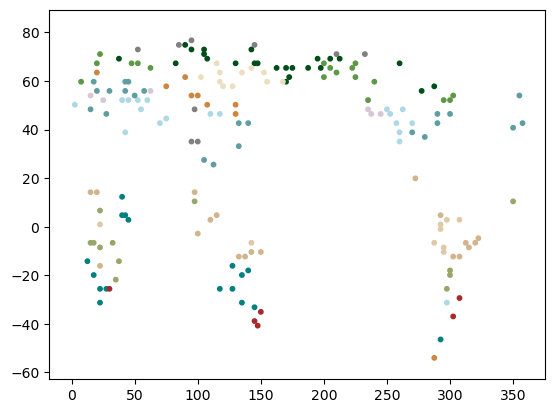

In [16]:
# plot 
from matplotlib.colors import ListedColormap
colors = [
    "grey",
    "#004D19","#5D9945","#E9DFC1",   # (tropic, tropic, savanna)
    "#DECAA7", "#D2B48C", # (grasslands, shrublands)
    "#97A669","lightblue","teal",# (mixed decid, conifer, larch)
    "cadetblue", "#D6C6D6",# (boreal forest, tundra)
    "peru","brown",
]

cmap = ListedColormap(colors, name="earth_biomes_19")

lats = sg.grid1d_lat.values
lons = sg.grid1d_lon.values

for i,var in enumerate(sg_biome_masks.data_vars):
    plt.scatter(lons,lats,10*sg_biome_masks[var],c=colors[i])

### Fullgrid

In [109]:
# Find PFTs that sum to > 80% of vegetated portion of gridcell
threshold=80

lats = surfdat.lat.values
lons = surfdat.lon.values

dom_pft_data = np.empty((len(lats), len(lons)), dtype=object)

for i, lat in enumerate(lats):
    for j, lon in enumerate(lons):
        if landfrac.sel(lat=lat,method='nearest').sel(lon=lon,method='nearest')>0.25:
            dat = surfdat.sel(lat=lat, method='nearest').sel(lon=lon, method='nearest')
            dom_pft_data[i, j] = get_dom_pfts(dat, threshold)

# Store in an xarray Dataset
ds_out = xr.Dataset(
    {
        "dom_pfts": (["lat", "lon"], dom_pft_data)
    },
    coords={
        "lat": lats,
        "lon": lons
    }
)


In [110]:
# create dataset of 2D biome masks
biome_masks = {}

lat_values = ds_out.lat.values
lon_values = ds_out.lon.values

for biome_name, pft_combos in veg_combos.items():
    # Create a binary mask for the biome
    biome_mask = np.zeros((len(lat_values), len(lon_values)), dtype=int)  

    for i, lat in enumerate(lat_values):
        for j, lon in enumerate(lon_values):
            dom_pfts = ds_out.dom_pfts.values[i, j] 
            
            if dom_pfts is not None:
                sorted_pfts = tuple(sorted(dom_pfts))  
                if sorted_pfts in pft_combos:
                    biome_mask[i, j] = 1  # Mark as 1 (true)

    # Store the mask in the dictionary
    biome_masks[biome_name] = (["lat", "lon"], biome_mask)


biome_ds = xr.Dataset(biome_masks, coords={"lat": lat_values, "lon": lon_values})


In [111]:
# plot all masks 

# Define a colormap for the biomes
biome_names = ['Tropical rainforest','Tropical savanna','Subtropical savanna','Broadleaf evergreen temperate tree','Grasslands','Shrubland',
               'Mixed deciduous temperate forest','Conifer forest','Siberian larch','Boreal forest','Broadleaf deciduous boreal trees','Boreal shrubland','Tundra']

# Create an empty array for the final categorical map
lat_values = biome_ds.lat.values
lon_values = biome_ds.lon.values
biome_map = np.zeros((len(lat_values), len(lon_values)))  # Default to 0 (background)

# Assign unique values to each biome
for idx, biome in enumerate(biome_names, start=1):
    biome_mask = biome_ds[biome].values
    biome_map[biome_mask == 1] = idx  # Assign unique integer value


In [120]:
wfile='/glade/u/home/djk2120/ctsm6_ppe/biomes/whit/whitkey.nc'
whit=xr.open_dataset(wfile)

In [121]:
ds_biome_maps = whit.copy()

In [122]:
ds_biome_maps['sudoku_biomes'] = (('lat', 'lon'), biome_map)

In [123]:
ds_biome_maps = ds_biome_maps.assign_coords(biome_names=biome_names)

In [124]:
ds_biome_maps = ds_biome_maps.drop_vars('biome_fg')
ds_biome_maps = ds_biome_maps.drop_vars('biome_name')

In [127]:
from matplotlib.colors import ListedColormap
colors = [
    "grey",
    "#004D19","#5D9945","darkseagreen","#E9DFC1",   # (tropic, tropic, savanna, eucalyptus)
    "#DECAA7", "#D2B48C", # (grasslands, shrublands)
    "#97A669","lightblue","teal",# (mixed decid, conifer, larch)
    "cadetblue","thistle","lavenderblush","lavender" # (boreal forest, aspen, boreal shrub, tundra)
    
]

cmap = ListedColormap(colors, name="earth_biomes_19")


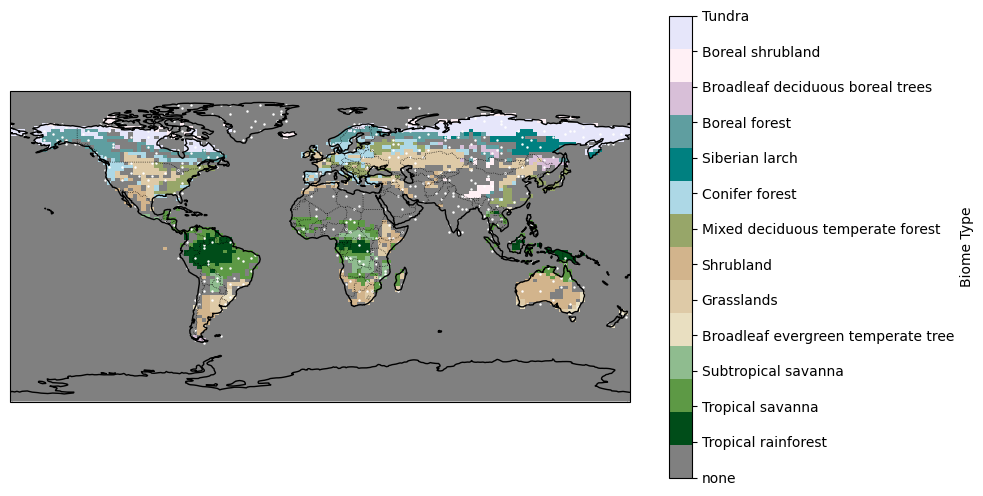

In [98]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
mesh = ax.pcolormesh(lon_values, lat_values, ds_biome_maps.sudoku_biomes, cmap=cmap, shading='auto')
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)

cbar = plt.colorbar(mesh,ticks=np.arange(0, len(biome_names) + 1))
cbar.set_label("Biome Type")
cbar.set_ticks(np.arange(0, len(biome_names) + 1))
cbar.set_ticklabels(np.concatenate([np.array(['none']), np.array(biome_names)]))

#plt.savefig('sudoku_biome_map.png')
plt.scatter(sg.grid1d_lon.values,sg.grid1d_lat.values,s=0.6,color='w')
plt.savefig('sudoku_biome_map_wSG.png')

In [131]:
ds_biome_maps.to_netcdf('../../biomes/sudoku_biomes.nc')